In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TextStreamer

tokenizer = AutoTokenizer.from_pretrained("NousResearch/OLMo-Bitnet-1B")
model = AutoModelForCausalLM.from_pretrained("NousResearch/OLMo-Bitnet-1B",
    torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto")

# streamer = TextStreamer(tokenizer)
# pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, pad_token_id=tokenizer.eos_token_id,
#     temperature=0.8, repetition_penalty=1.1, do_sample=True,streamer=streamer)
# pipe("The capitol of Paris is",  max_new_tokens=256)

C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


In [3]:
tokens = tokenizer("The capitol of Paris is", return_tensors="pt").to(model.device)

In [4]:
tokens

{'input_ids': tensor([[  510,  1729, 16180,   273,  7785,   310]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [5]:
# out = model.generate(input_ids=tokens.input_ids, attention_mask=tokens.attention_mask, max_length=256, pad_token_id=tokenizer.eos_token_id, temperature=0.8, repetition_penalty=1.1, do_sample=True)

C:\Users\paulh\.cache\huggingface\modules\transformers_modules\NousResearch\OLMo-Bitnet-1B\9c9783f0983e51c6dfe84e22c054611ba4eae27f\model.py:556: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return F.scaled_dot_product_attention(


In [6]:
out = model.forward(input_ids=tokens.input_ids, attention_mask=tokens.attention_mask, output_hidden_states=True, return_dict=True)

In [7]:
dir(out)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'logits',
 'loss',
 'move_to_end',
 'past_key_values',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [8]:
last_hidden_state = out.hidden_states[-1]

mean_pooled = last_hidden_state.mean(dim=1)
max_pooled, _ = last_hidden_state.max(dim=1)
combined = torch.cat((mean_pooled, max_pooled), dim=1)

In [9]:
import json
actions = json.loads(open("actions.json").read())

In [10]:
actions

{'move': ['forward',
  'backward',
  'Jump',
  'Duck',
  'Crouch',
  'Run',
  'Walk',
  'Turn left',
  'Turn right',
  'Strafe left',
  'Strafe right',
  'Climb ladder',
  'Swim',
  'Fly up',
  'Descend',
  'Sprint',
  'Slide',
  'Roll',
  'Hover',
  'Teleport',
  'Ascend stairs',
  'Glide'],
 'object': ['Pick up',
  'Drop item',
  'Open door',
  'Close door',
  'Push button',
  'Pull lever',
  'Use key',
  'Read note',
  'Equip weapon',
  'Unequip item',
  'Reload weapon',
  'Inspect item',
  'Craft item',
  'Trade item',
  'Charge device',
  'Plant bomb',
  'Disarm trap',
  'Activate switch'],
 'combat': ['Attack with item',
  'Shoot',
  'Fire gun',
  'Throw grenade',
  'Cast spell',
  'Block attack',
  'Dodge',
  'Use shield',
  'Perform combo attack',
  'Use special ability',
  'Parry attack',
  'Aim down sights',
  'Melee strike',
  'Charge attack',
  'Advance',
  'Summon ally',
  'Stealth kill',
  'Disengage'],
 'strategy': ['Build structure',
  'Harvest resources',
  'Deploy uni

In [11]:
def last_token_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

In [12]:
from enum import Enum

class ActionType(Enum):
    movements = "movements"
    object_interactions = "object_interactions"
    combat_actions = "combat_actions"
    strategy_commands = "strategy_commands"
    board_game_actions = "board_game_actions"
    miscellaneous_actions = "miscellaneous_actions"

class EmbeddingMethod(Enum):
    mean = 1
    max = 2
    combined = 3
    last_token_pool = 4


prompt = lambda action_typ, action: f"{action_typ}: {action}"

def embed_actions(method: EmbeddingMethod):
    with torch.no_grad():
        embeddings = {}
        for key, action_type in actions.items():
            action_embeddings = {}
            for action in action_type:
                tokens = tokenizer(prompt(key, action), return_tensors="pt").to(model.device)
                out = model.forward(input_ids=tokens.input_ids, attention_mask=tokens.attention_mask, output_hidden_states=True, return_dict=True)
                print(f"processed key: {key}, action: {action}")
                last_hidden_state = out.hidden_states[-1]
                if method == EmbeddingMethod.mean:
                    action_embeddings[action] = last_hidden_state.mean(dim=1)
                elif method == EmbeddingMethod.max:
                    action_embeddings[action], _ = last_hidden_state.max(dim=1)
                elif method == EmbeddingMethod.combined:
                    mean_pooled = last_hidden_state.mean(dim=1)
                    max_pooled, _ = last_hidden_state.max(dim=1)
                    action_embeddings[action] = torch.cat((mean_pooled, max_pooled), dim=1)
                elif method == EmbeddingMethod.last_token_pool:
                    action_embeddings[action] = last_token_pool(last_hidden_state, tokens.attention_mask)
                del out.hidden_states
            embeddings[key] = action_embeddings
        return embeddings


In [13]:
embeds = embed_actions(EmbeddingMethod.max)

processed key: move, action: forward
processed key: move, action: backward
processed key: move, action: Jump
processed key: move, action: Duck
processed key: move, action: Crouch
processed key: move, action: Run
processed key: move, action: Walk
processed key: move, action: Turn left
processed key: move, action: Turn right
processed key: move, action: Strafe left
processed key: move, action: Strafe right
processed key: move, action: Climb ladder
processed key: move, action: Swim
processed key: move, action: Fly up
processed key: move, action: Descend
processed key: move, action: Sprint
processed key: move, action: Slide
processed key: move, action: Roll
processed key: move, action: Hover
processed key: move, action: Teleport
processed key: move, action: Ascend stairs
processed key: move, action: Glide
processed key: object, action: Pick up
processed key: object, action: Drop item
processed key: object, action: Open door
processed key: object, action: Close door
processed key: object, a

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_action_embeddings(embedding_dict, annotate_names=False):
    # Initialize PCA, reducing to two components
    pca = PCA(n_components=2)
    
    # Prepare data for PCA
    all_vectors = []
    labels = []
    colors = []
    action_names = []
    
    color_map = {'move': 'red', 'object': 'blue', 'combat': 'green', 'strategy': 'yellow', 'board': 'purple', 'miscellaneous': 'orange'}  # Add more colors as needed
    
    for label, actions in embedding_dict.items():
        for action, vector in actions.items():
            vectors = [vector.squeeze(0).float().cpu().numpy()]
            all_vectors.extend(vectors)
            labels.extend([label] * len(vectors))
            action_names.extend([action] * len(vectors))
            colors.extend([color_map[label]] * len(vectors))
    
    # Fit and transform the data
    reduced_vectors = pca.fit_transform(all_vectors)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=label, color=colors[i], alpha=0.7)
        if annotate_names:
            plt.annotate(action_names[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    
    # Create a legend, but only for unique labels
    handles, unique_labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, unique_labels)) if l not in unique_labels[:i]]
    plt.legend(*zip(*unique))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Action Embeddings 2D Projection')
    plt.show()

In [36]:
embeds['move']['Jump'].shape

torch.Size([1, 2048])

In [37]:
embeds

{'move': {'forward': tensor([[ 0.8164, -1.3594,  0.6445,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'backward': tensor([[ 0.4609, -0.2539,  0.6445,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Jump': tensor([[ 0.1670, -1.0078,  0.6445,  ..., -1.7109,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Duck': tensor([[ 0.1670, -0.9414,  0.6562,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Crouch': tensor([[ 1.1797, -0.4082,  2.5000,  ...,  0.0320,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Run': tensor([[ 0.1670, -0.6055,  0.6445,  ..., -1.2344,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Walk': tensor([[ 0.1670, -0.5156,  0.6445,  ..., -0.5898,  1.1484,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Turn left': tensor([[ 0.1670,  0.0535,  0.6445,  ..., -1.5312,  1.0234,

In [38]:
selection = ["forward",
        "backward",
        "Jump",
        "Duck",
        "Crouch",
        "Run",
        "Walk",
        "Turn left",
        "Turn right"]

f = lambda embed_action_pairs: {key: value for key, value in embed_action_pairs.items() if key in selection}

only_a_few = {key: f(value) for key, value in embeds.items() if key in ['move']}
only_a_few

{'move': {'forward': tensor([[ 0.8164, -1.3594,  0.6445,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'backward': tensor([[ 0.4609, -0.2539,  0.6445,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Jump': tensor([[ 0.1670, -1.0078,  0.6445,  ..., -1.7109,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Duck': tensor([[ 0.1670, -0.9414,  0.6562,  ..., -2.4375,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Crouch': tensor([[ 1.1797, -0.4082,  2.5000,  ...,  0.0320,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Run': tensor([[ 0.1670, -0.6055,  0.6445,  ..., -1.2344,  1.0234,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Walk': tensor([[ 0.1670, -0.5156,  0.6445,  ..., -0.5898,  1.1484,  2.7656]],
         device='cuda:0', dtype=torch.bfloat16),
  'Turn left': tensor([[ 0.1670,  0.0535,  0.6445,  ..., -1.5312,  1.0234,

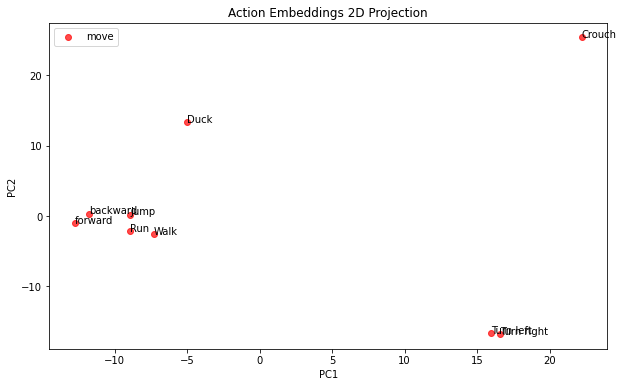

In [39]:
plot_action_embeddings(only_a_few, annotate_names=True)

In [33]:
from sklearn.manifold import TSNE

def plot_action_embeddings_tsne(embedding_dict, annotate_names=False):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)

    all_vectors = []
    labels = []
    colors = []
    action_names = []
    
    color_map = {'move': 'red', 'object': 'blue', 'combat': 'green', 'strategy': 'yellow', 'board': 'purple', 'miscellaneous': 'orange'}
    
    for label, actions in embedding_dict.items():
        for action, vector in actions.items():
            vectors = [vector.squeeze(0).float().cpu().numpy()]
            all_vectors.extend(vectors)
            labels.extend([label] * len(vectors))
            action_names.extend([action] * len(vectors))
            colors.extend([color_map[label]] * len(vectors))
    
    # Fit and transform the data
    reduced_vectors = tsne.fit_transform(all_vectors)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=label, color=colors[i], alpha=0.7)
        # anotate the point with its action name
        if annotate_names:
            plt.annotate(action_names[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    
    # Create a legend, but only for unique labels
    handles, unique_labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, unique_labels)) if l not in unique_labels[:i]]
    plt.legend(*zip(*unique))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Action Embeddings TSNE Projection')
    plt.show()

C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


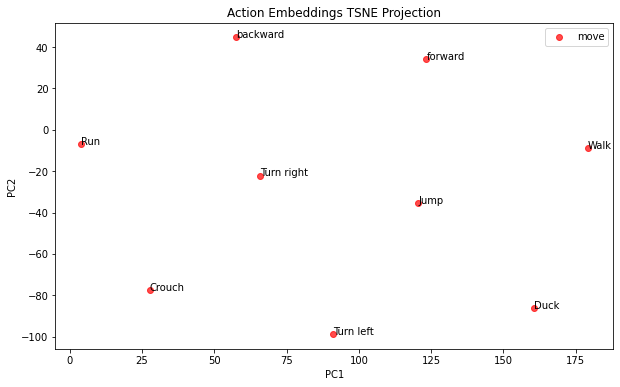

In [34]:
plot_action_embeddings_tsne(only_a_few)